# 1. About

Speed tests of the same agent-based model (ABM) written in:

* pure ("native") Python
    - using lists, or;
    - using object orientation (OO)
* NumPy
* Numba
    - pure NumPy
    - "mixed" native Python and NumPy
    
## 1.1 The model
    
The ABM is a version of the trading game presented in the [Mesa docs](https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html) and based on models described in [Dragulescu and Yakovenko (2002)](https://arxiv.org/pdf/cond-mat/0211175.pdf). (I don't implement a version of the model with Mesa, but the OO implemention below is pretty similar.)

Agents begin with one dollar of wealth. In each sweep of the model each agent with positive wealth gives a dollar to another agent chose at random, with replacement. That's it.

After many sweeps the income distribution becomes skewed-right. A select few agents end up with large incomes. Most end up with nothing.  

In [1]:
import random as random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numba as numba
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

# 2. Model implementations

## 2.1 Native (non-OO)

In [2]:
def abm_native(n_agents = 100, n_rounds = 100, n_trials = 100):
    trials = []
    for trial in range(n_trials):
        a = [[i, 1] for i in range(n_agents)] 
        for i in range(n_rounds):
            for agent in a:
                if agent[1] > 0:
                    other_agent = random.choice(a)
                    if agent[0] != other_agent[0]:
                        other_agent[1] += 1
                        agent[1] -= 1
        wealth = [agent[1] for agent in a]
        trials.append(wealth)
    return(trials)

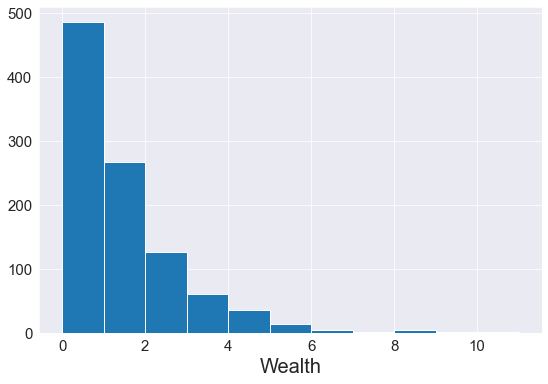

In [3]:
x = abm_native(n_trials=10,n_agents=100, n_rounds=100)
x = np.array(x).flatten()
plt.figure(figsize=(9,6))
plt.hist(x, bins=range(max(x)+1))
plt.xlabel("Wealth", fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

## 2.2 Native (OO)

In [4]:
def abm_native_OO(n_agents = 100, n_rounds = 100, n_trials = 100):

    # agent
    class agent(object):
        def __init__(self):
            self.wealth = 1
            self.id = None
    # game
    class game(object):
        def __init__(self, n_agents, n_rounds):
            self.n_agents = n_agents
            self.n_rounds = n_rounds
            self.instantiate_agents()
            self.id_agents()

        def instantiate_agents(self):
            self.agents = [agent() for i in range(self.n_agents)]

        def id_agents(self):
            ids = [i for i in range(self.n_agents)]
            for agent,i in zip(self.agents,ids):
                agent.id = i

        def play_game(self):
            for i in range(self.n_rounds):
                for agent in self.agents:
                    if agent.wealth > 0:
                        other_agent = random.choice(self.agents)
                        if other_agent.id != agent.id:
                            other_agent.wealth +=1
                            agent.wealth -=1
                self.wealth = [agent.wealth for agent in self.agents]
                pass

    # run trials of the game and collect data            
    trials = []
    for trial in range(n_trials):
        g = game(n_agents=n_agents, n_rounds=n_rounds)
        g.play_game()
        trials.append(g.wealth)
    return(trials)

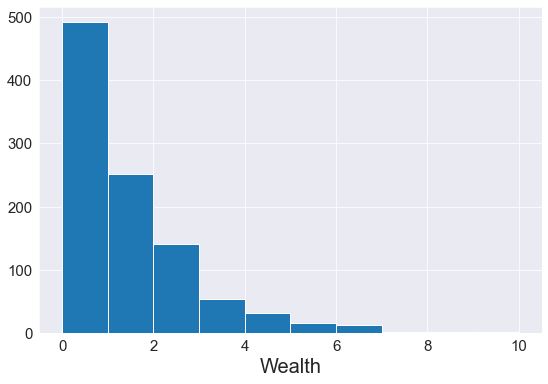

In [5]:
x = abm_native_OO(n_trials=10,n_agents=100, n_rounds=100)
x = np.array(x).flatten()
plt.figure(figsize=(9,6))
plt.hist(x, bins=range(max(x)+1))
plt.xlabel("Wealth", fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

## 2.3 Numpy

In [6]:
def abm_numpy(n_agents = 100, n_rounds = 100, n_trials = 100):
    trial_data = np.zeros(shape=(n_agents, n_trials))
    for trial in range(n_trials):
        a = np.zeros(shape=(n_agents,4), dtype=int)
        a[:,0], a[:,3] = np.arange(n_agents), 1
        for i in range(n_rounds):
            a[:,1] = np.random.choice(a[:,0],n_agents, replace=True)
            a[:,2] = np.bincount(a[(a[:,3]>0) & (a[:,0] != a[:,1])][:,1], minlength=n_agents)
            a[:,3][(a[:,3] > 0) & (a[:,0] != a[:,1])] -= 1
            a[:,3] += a[:,2]
        trial_data[:,trial] = a[:,3]
    return(trial_data.flatten())

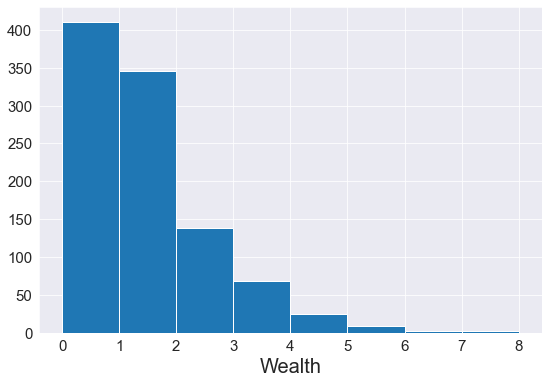

In [7]:
x = abm_numpy(n_trials=10,n_agents=100, n_rounds=100)
plt.figure(figsize=(9,6))
plt.hist(x, bins=range(np.max(x).astype(int)+1))
plt.xlabel("Wealth", fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

## 2.4 Numba

Jitting the pure numpy version:

In [8]:
@numba.njit
def abm_numba_numpy(n_agents = 100, n_rounds = 100, n_trials = 100):
    trial_data = np.zeros(shape=(n_agents, n_trials))
    for trial in range(n_trials):
        a = np.zeros(shape=(n_agents,4), dtype=numba.int32)
        a[:,0], a[:,3] = np.arange(n_agents), 1
        for i in range(n_rounds):
            a[:,1] = np.random.choice(a[:,0],n_agents, replace=True)
            a[:,2] = np.bincount(a[(a[:,3]>0) & (a[:,0] != a[:,1])][:,1], minlength=n_agents)
            a[:,3][(a[:,3] > 0) & (a[:,0] != a[:,1])] -= 1
            a[:,3] += a[:,2]
        trial_data[:,trial] = a[:,3]
    return(trial_data.flatten())

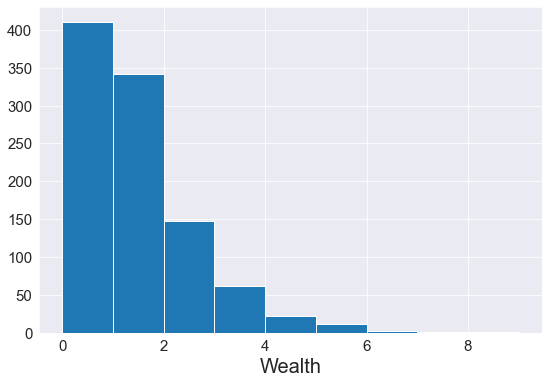

In [9]:
x = abm_numba_numpy(n_trials=10,n_agents=100, n_rounds=100)
plt.figure(figsize=(9,6))
plt.hist(x, bins=range(np.max(x).astype(int)+1))
plt.xlabel("Wealth", fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

Jitting a "mixed" version, since Numba prefers NumPy arrays over native lists:

In [10]:
@numba.njit
def abm_numba_mixed(n_agents = 100, n_rounds = 100, n_trials = 100):
    trial_data = np.zeros(shape=(n_agents, n_trials))
    for trial in range(n_trials):
        a = np.zeros(shape=(n_agents,2), dtype=numba.int32)
        a[:,0], a[:,1] = np.arange(n_agents), 1
        for i in range(n_rounds):
            for agent in a:
                if agent[1] > 0:
                    other_agent = a[np.random.choice(np.arange(n_agents)),:]
                    if agent[0] != other_agent[0]:
                        other_agent[1] += 1
                        agent[1] -= 1
        trial_data[:,trial] = a[:,1]
    return(trial_data.flatten())

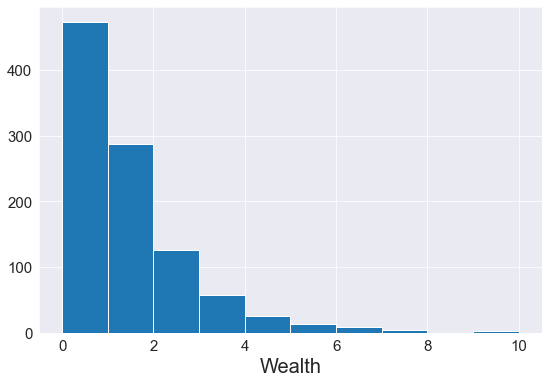

In [11]:
x = abm_numba_mixed(n_trials=10,n_agents=100, n_rounds=100)
plt.figure(figsize=(9,6))
plt.hist(x, bins=range(np.max(x).astype(int)+1))
plt.xlabel("Wealth", fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

# 3. Speed tests

Run each model with `%timeit` (5 trials, 10 loops per trial, save the output with `-o` flag):

In [12]:
def speed_tests(test_agent_size=True, baseline=100):
    time_native, time_native_OO, time_numpy, time_numba_numpy, time_numba_mixed = [], [], [], [], []
    iterations = [10**i for i in range(1,4,1)] # log scale
    for i in iterations:
        if test_agent_size==True:
            runtime_native = %timeit -o -n 10 -r 5 abm_native(n_trials=1, n_rounds=baseline, n_agents=i)
            runtime_native_OO = %timeit -o -n 10 -r 5 abm_native_OO(n_trials=1, n_rounds=baseline, n_agents=i)
            runtime_numpy = %timeit -o -n 10 -r 5 abm_numpy(n_trials=1, n_rounds=baseline, n_agents=i)
            runtime_numba_numpy = %timeit -o -n 10 -r 5 abm_numba_numpy(n_trials=1, n_rounds=baseline, n_agents=i)
            runtime_numba_mixed = %timeit -o -n 10 -r 5 abm_numba_mixed(n_trials=1, n_rounds=baseline, n_agents=i)
        else:
            runtime_native = %timeit -o -n 10 -r 5 abm_native(n_trials=1,n_rounds=i,n_agents=baseline)
            runtime_native_OO = %timeit -o -n 10 -r 5 abm_native_OO(n_trials=1, n_rounds=i, n_agents=baseline)            
            runtime_numpy = %timeit -o -n 10 -r 5 abm_numpy(n_trials=1,n_rounds=i,n_agents=baseline)            
            runtime_numba_numpy = %timeit -o -n 10 -r 5 abm_numba_numpy(n_trials=1,n_rounds=i,n_agents=baseline)
            runtime_numba_mixed = %timeit -o -n 10 -r 5 abm_numba_mixed(n_trials=1, n_rounds=baseline, n_agents=i)            
        time_native.append(runtime_native)
        time_native_OO.append(runtime_native_OO)        
        time_numpy.append(runtime_numpy)
        time_numba_numpy.append(runtime_numba_numpy)
        time_numba_mixed.append(runtime_numba_mixed)        
    data_native, data_native_OO, data_numpy, data_numba_numpy, data_numba_mixed = [], [], [], [], []
    for i,j in zip(iterations, range(len(iterations))):
        data_native.append([i, np.mean(time_native[j].timings)])
        data_native_OO.append([i, np.mean(time_native_OO[j].timings)])        
        data_numpy.append([i, np.mean(time_numpy[j].timings)])
        data_numba_numpy.append([i, np.mean(time_numba_numpy[j].timings)])
        data_numba_mixed.append([i, np.mean(time_numba_mixed[j].timings)])        
    df0 = pd.DataFrame(data_native, columns=['n', 'mean_time'])
    df0['version'] = 'Native (non-OO)'
    df0['version_n'] = 0
    df1 = pd.DataFrame(data_native_OO, columns=['n', 'mean_time'])
    df1['version'] = 'Native (OO)'
    df1['version_n'] = 1    
    df2 = pd.DataFrame(data_numpy, columns=['n', 'mean_time'])
    df2['version'] = 'NumPy'
    df2['version_n'] = 2
    df3 = pd.DataFrame(data_numba_numpy, columns=['n', 'mean_time'])
    df3['version'] = 'Numba+NumPy'    
    df3['version_n'] = 3    
    df4 = pd.DataFrame(data_numba_mixed, columns=['n', 'mean_time'])
    df4['version'] = 'Numba+Mixed (Native & NumPy)'        
    df4['version_n'] = 4    
    df = pd.concat([df0, df1, df2, df3, df4])
    return(df)

Run the speed tests (the magic `%%capture` suppresses `%timeit` printout):

In [13]:
%%capture
df_rounds = speed_tests(test_agent_size=False)
df_agents = speed_tests(test_agent_size=True)

Plot the results:

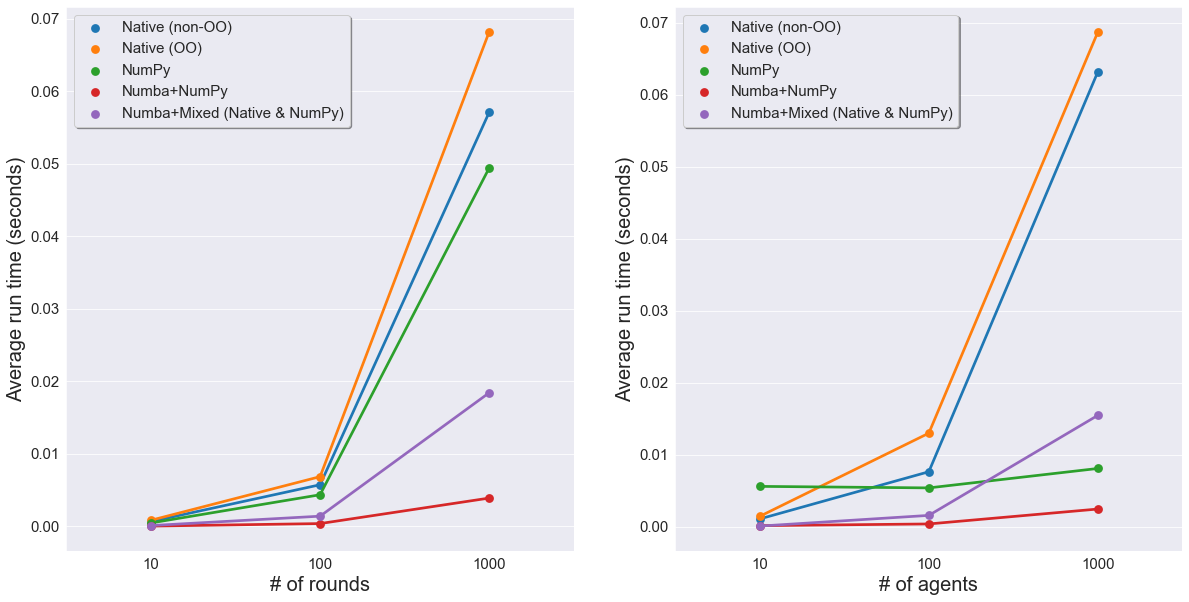

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20, 10))
f1 = sns.pointplot(x="n", y="mean_time", hue='version', data=df_rounds, ax=ax1);
legend = f1.legend()
f1.tick_params(labelsize=15)
f1.set_xlabel("# of rounds", fontsize=20)
f1.set_ylabel("Average run time (seconds)", fontsize=20)
ax1.legend(fontsize=15, frameon=True, shadow=True)
f2 = sns.pointplot(x="n", y="mean_time", hue='version',  data=df_agents, ax=ax2);
f2.tick_params(labelsize=15)
f2.set_xlabel("# of agents", fontsize=20)
f2.set_ylabel("Average run time (seconds)", fontsize=20)
legend = ax2.legend()
ax2.legend(fontsize=15, frameon=True, shadow=True)
ax2.yaxis.set_tick_params(which='both', labelbottom=True)
plt.show()

In [15]:
df_rounds[df_rounds['n'] == 1000]

,n,mean_time,version,version_n
2,1000,0.057084,Native (non-OO),0
2,1000,0.068169,Native (OO),1
2,1000,0.049409,NumPy,2
2,1000,0.003902,Numba+NumPy,3
2,1000,0.018419,Numba+Mixed (Native & NumPy),4


In [16]:
df_agents[df_agents['n'] == 1000]

,n,mean_time,version,version_n
2,1000,0.063185,Native (non-OO),0
2,1000,0.068706,Native (OO),1
2,1000,0.008112,NumPy,2
2,1000,0.002481,Numba+NumPy,3
2,1000,0.015491,Numba+Mixed (Native & NumPy),4
